# <center> SLU-lite (FSC) </center>

In [1]:
!nvidia-smi

Sat Jan  3 12:32:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/VuTrinhNguyenHoang/Speech-Emotion-Learning.git speech.ser
%cd speech.ser
!ls

Cloning into 'speech.ser'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 97 (delta 48), reused 72 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 832.66 KiB | 18.50 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/kaggle/working/speech.ser
notebooks  README.md  requirements.txt	scripts  src


In [3]:
!pip -q install -r requirements.txt

In [4]:
# copy the dataset from kaggle input 
!mkdir -p data/raw/FSC
!cp -r /kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset/data data/raw/FSC/data
!cp -r /kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset/wavs data/raw/FSC/wavs

In [5]:
# create intent columns
from src.paths import RAW_DIR
import pandas as pd

FSC_RAW_DIR = RAW_DIR / "FSC"
train_csv = FSC_RAW_DIR / "data" / "train_data.csv"
valid_csv = FSC_RAW_DIR / "data" / "valid_data.csv"
test_csv = FSC_RAW_DIR / "data" / "test_data.csv"

df_tr = pd.read_csv(train_csv)
df_va = pd.read_csv(valid_csv)
df_te = pd.read_csv(test_csv)

def add_intent(df):
    # intent = action__object__location
    df = df.copy()
    df["intent"] = df["action"].astype(str) + "__" + df["object"].astype(str) + "__" + df["location"].astype(str)
    return df

df_tr = add_intent(df_tr)
df_va = add_intent(df_va)
df_te = add_intent(df_te)

print(len(df_tr), len(df_va), len(df_te))
df_tr.head()

23132 3118 3793


,Unnamed: 0,path,speakerId,transcription,action,object,location,intent
0,0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none,change language__none__none
1,1,wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...,2BqVo8kVB2Skwgyb,Resume,activate,music,none,activate__music__none
2,2,wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...,2BqVo8kVB2Skwgyb,Turn the lights on,activate,lights,none,activate__lights__none
3,3,wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...,2BqVo8kVB2Skwgyb,Switch on the lights,activate,lights,none,activate__lights__none
4,4,wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-1...,2BqVo8kVB2Skwgyb,Switch off the lights,deactivate,lights,none,deactivate__lights__none


In [6]:
from pathlib import Path

def resolve_path(rel_path: str) -> str:
    return str(FSC_RAW_DIR / rel_path)

for df in [df_tr, df_va, df_te]:
    df["path"] = df["path"].apply(resolve_path)

print("exits?", Path(df_tr.loc[0, "path"]).exists(), df_tr.loc[0, "path"])

exits? True /kaggle/working/speech.ser/data/raw/FSC/wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-11e9-a9a5-5dbec3b8816a.wav


In [7]:
from src.paths import SPLITS_DIR
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

keep_cols = ["path", "speakerId", "transcription", "action", "object", "location", "intent"]
df_tr_out = df_tr[keep_cols].rename(columns={"speakerId": "speaker"})
df_va_out = df_va[keep_cols].rename(columns={"speakerId": "speaker"})
df_te_out = df_te[keep_cols].rename(columns={"speakerId": "speaker"})

df_tr_out.to_csv(SPLITS_DIR / "fsc_train.csv", index=False)
df_va_out.to_csv(SPLITS_DIR / "fsc_val.csv", index=False)
df_te_out.to_csv(SPLITS_DIR / "fsc_test.csv", index=False)

!ls data/splits | grep fsc

fsc_test.csv
fsc_train.csv
fsc_val.csv


In [8]:
tr_spk = set(df_tr_out["speaker"].unique())
va_spk = set(df_va_out["speaker"].unique())
te_spk = set(df_te_out["speaker"].unique())

print("num speakers:", len(tr_spk), len(va_spk), len(te_spk))
print(f'\nSpeaker Independence Check:')
print("Train ∩ Val:", len(tr_spk & va_spk))
print("Train ∩ Test:", len(tr_spk & te_spk))
print("Val ∩ Test:", len(va_spk & te_spk))

num speakers: 77 10 10

Speaker Independence Check:
Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


# <center> Quick EDA </center>

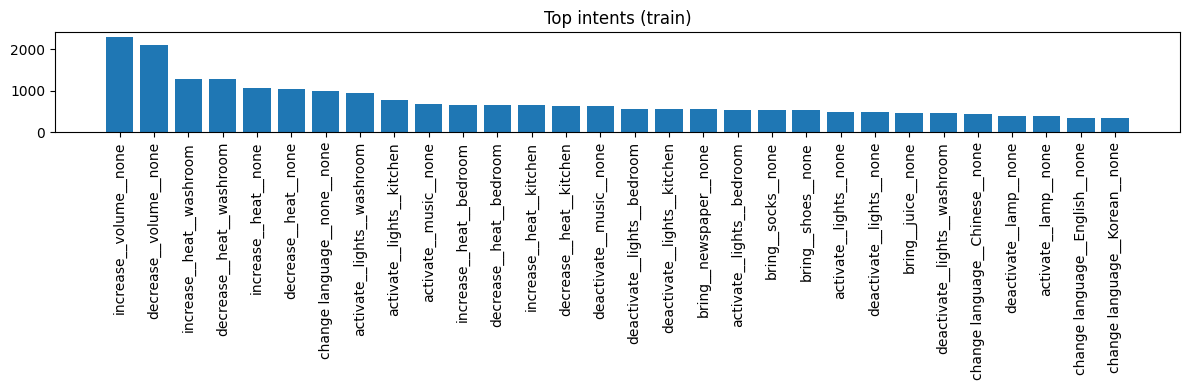

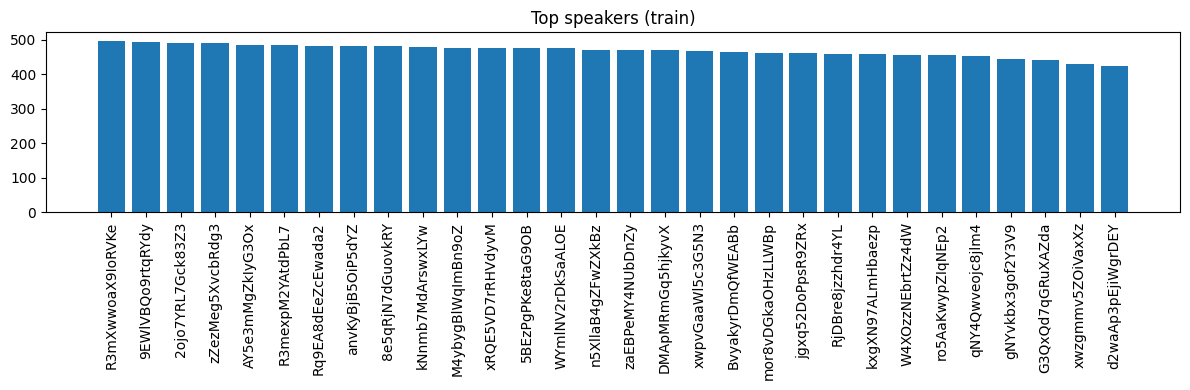

Num intents: 31
Num speakers: 77


In [9]:
import matplotlib.pyplot as plt

intent_counts = df_tr_out["intent"].value_counts()
spk_counts = df_tr_out["speaker"].value_counts()

plt.figure(figsize=(12,4))
top = intent_counts.head(30)
plt.bar(range(len(top)), top.values)
plt.xticks(range(len(top)), top.index, rotation=90)
plt.title("Top intents (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
top = spk_counts.head(30)
plt.bar(range(len(top)), top.values)
plt.xticks(range(len(top)), top.index, rotation=90)
plt.title("Top speakers (train)")
plt.tight_layout()
plt.show()

print("Num intents:", df_tr_out["intent"].nunique())
print("Num speakers:", df_tr_out["speaker"].nunique())

In [10]:
demo = pd.read_csv(FSC_RAW_DIR / "data" / "speaker_demographics.csv")
print("Demographics columns:", demo.columns.tolist())
demo.head()

Demographics columns: ['speakerId', 'Self-reported fluency level ', 'First Language spoken', 'Current language used for work/school', 'gender', 'ageRange']


,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,eLQ3mNg27GHLkDej,native,English (United States),English (United States),male,22-40
1,7NqqnAOPVVSKnxyv,native,English (United States),English (United States),male,22-40
2,ZebMRl5Z7dhrPKRD,native,English (United States),English (United States),male,41-65
3,7NEaXjeLX3sg3yDB,native,English (United States),English (United States),male,41-65
4,jgxq52DoPpsR9ZRx,native,English (United States),English (United States),male,22-40


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

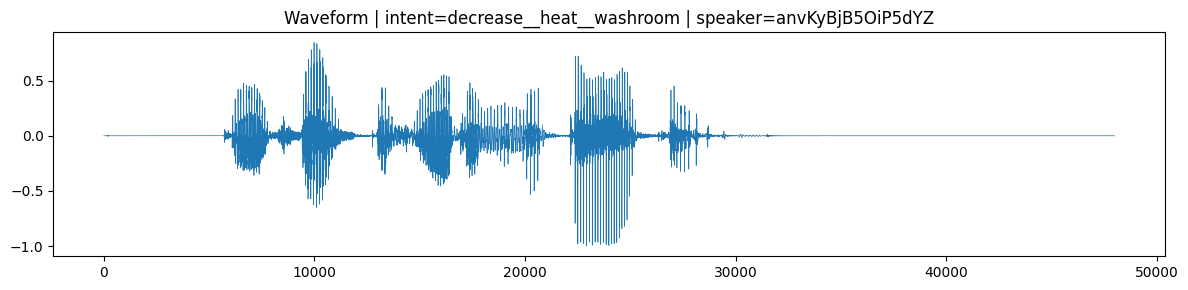

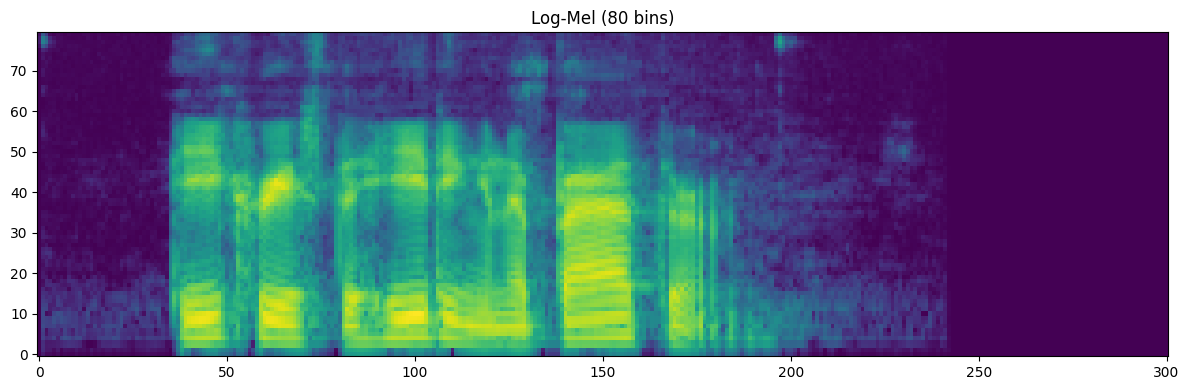

In [11]:
import random
from src.config import SAMPLE_RATE, DURATION_SEC
from src.data.audio import load_mono_resample, pad_or_crop, peak_normalize
from src.data.features import log_mel

sample = df_tr_out.sample(1, random_state=42).iloc[0]
wav_path = sample["path"]

wav, _ = load_mono_resample(wav_path, SAMPLE_RATE)
wav = peak_normalize(wav)
wav = pad_or_crop(wav, int(SAMPLE_RATE * DURATION_SEC))
lm = log_mel(wav)

plt.figure(figsize=(12,3))
plt.plot(wav.squeeze(0).numpy(), linewidth=0.5)
plt.title(f"Waveform | intent={sample['intent']} | speaker={sample['speaker']}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.imshow(lm.numpy(), aspect="auto", origin="lower")
plt.title("Log-Mel (80 bins)")
plt.tight_layout(); plt.show()

In [12]:
import json

intents = sorted(df_tr_out["intent"].unique().tolist())
intent2id = {k:i for i,k in enumerate(intents)}
id2intent = {i:k for k,i in intent2id.items()}

with open(SPLITS_DIR / "fsc_label_map.json", "w", encoding="utf-8") as f:
    json.dump({"intent2id": intent2id, "id2intent": id2intent}, f, ensure_ascii=False, indent=2)

print("Num intents:", len(intents))

Num intents: 31


In [13]:
# Cache log-mel
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

from src.data.cache import cache_all_splits_fsc
from src.paths import PROCESSED_DIR

cache_all_splits_fsc(
    SPLITS_DIR / "fsc_train.csv",
    SPLITS_DIR / "fsc_val.csv",
    SPLITS_DIR / "fsc_test.csv",
    PROCESSED_DIR / "fsc_logmel_3s_16k_nmel80",
    intent2id
)

Cache fsc_train.csv:   0%|          | 0/23132 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.co

[OK] wrote=23132, skipped(existing)=0, out_dir=/kaggle/working/speech.ser/data/processed/fsc_logmel_3s_16k_nmel80/train


Cache fsc_val.csv:   0%|          | 0/3118 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/p

[OK] wrote=3118, skipped(existing)=0, out_dir=/kaggle/working/speech.ser/data/processed/fsc_logmel_3s_16k_nmel80/val


Cache fsc_test.csv:   0%|          | 0/3793 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/

[OK] wrote=3793, skipped(existing)=0, out_dir=/kaggle/working/speech.ser/data/processed/fsc_logmel_3s_16k_nmel80/test


# <center> Deep Learning </center>

In [14]:
!python -m src.train_slu --arch SimpleCNN --batch_size 64 --epochs 30 --lr 0.001 --num_workers 4 --seed 42 --patience 5

Epoch 01 | train_loss=3.0957 | val_loss=3.0700 | val_macroF1=0.0228
  [OK] saved best -> best_slu_simplecnn.pt (val_macroF1=0.0228)
Epoch 02 | train_loss=2.9533 | val_loss=2.9480 | val_macroF1=0.0475
  [OK] saved best -> best_slu_simplecnn.pt (val_macroF1=0.0475)
Epoch 03 | train_loss=2.8782 | val_loss=2.9686 | val_macroF1=0.0566
  [OK] saved best -> best_slu_simplecnn.pt (val_macroF1=0.0566)
Epoch 04 | train_loss=2.8139 | val_loss=3.0647 | val_macroF1=0.0458
Epoch 05 | train_loss=2.7562 | val_loss=3.0453 | val_macroF1=0.0590
  [OK] saved best -> best_slu_simplecnn.pt (val_macroF1=0.0590)
Epoch 06 | train_loss=2.7158 | val_loss=2.7901 | val_macroF1=0.0698
  [OK] saved best -> best_slu_simplecnn.pt (val_macroF1=0.0698)
Epoch 07 | train_loss=2.6644 | val_loss=3.0232 | val_macroF1=0.0527
Epoch 08 | train_loss=2.6285 | val_loss=3.0479 | val_macroF1=0.0556
Epoch 09 | train_loss=2.5951 | val_loss=2.8239 | val_macroF1=0.0751
  [OK] saved best -> best_slu_simplecnn.pt (val_macroF1=0.0751)
Epoc

In [15]:
!python -m src.train_slu --arch ResNet18 --batch_size 64 --epochs 30 --lr 0.001 --num_workers 4 --seed 42 --patience 5

Epoch 01 | train_loss=1.4091 | val_loss=1.7799 | val_macroF1=0.4976
  [OK] saved best -> best_slu_resnet18.pt (val_macroF1=0.4976)
Epoch 02 | train_loss=0.4355 | val_loss=2.9737 | val_macroF1=0.4797
Epoch 03 | train_loss=0.2540 | val_loss=0.5186 | val_macroF1=0.8495
  [OK] saved best -> best_slu_resnet18.pt (val_macroF1=0.8495)
Epoch 04 | train_loss=0.1684 | val_loss=0.4369 | val_macroF1=0.8729
  [OK] saved best -> best_slu_resnet18.pt (val_macroF1=0.8729)
Epoch 05 | train_loss=0.1210 | val_loss=0.5347 | val_macroF1=0.8398
Epoch 06 | train_loss=0.0881 | val_loss=0.5423 | val_macroF1=0.8766
  [OK] saved best -> best_slu_resnet18.pt (val_macroF1=0.8766)
Epoch 07 | train_loss=0.0785 | val_loss=0.4388 | val_macroF1=0.8772
  [OK] saved best -> best_slu_resnet18.pt (val_macroF1=0.8772)
Epoch 08 | train_loss=0.0653 | val_loss=0.5271 | val_macroF1=0.8826
  [OK] saved best -> best_slu_resnet18.pt (val_macroF1=0.8826)
Epoch 09 | train_loss=0.0454 | val_loss=0.5842 | val_macroF1=0.8767
Epoch 10 |

In [16]:
!python -m src.train_slu --arch Transformer --batch_size 64 --epochs 30 --lr 0.0006 --num_workers 4 --seed 42 --patience 5

Epoch 01 | train_loss=2.2020 | val_loss=2.0952 | val_macroF1=0.3159
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.3159)
Epoch 02 | train_loss=1.3051 | val_loss=1.4222 | val_macroF1=0.5301
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.5301)
Epoch 03 | train_loss=0.9014 | val_loss=1.1974 | val_macroF1=0.6539
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.6539)
Epoch 04 | train_loss=0.6713 | val_loss=1.0679 | val_macroF1=0.7012
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.7012)
Epoch 05 | train_loss=0.5097 | val_loss=0.8690 | val_macroF1=0.7590
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.7590)
Epoch 06 | train_loss=0.4175 | val_loss=0.9729 | val_macroF1=0.7367
Epoch 07 | train_loss=0.3589 | val_loss=0.8368 | val_macroF1=0.7768
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.7768)
Epoch 08 | train_loss=0.3036 | val_loss=0.7084 | val_macroF1=0.8025
  [OK] saved best -> best_slu_transformer.pt (val_macroF1=0.

---